# Classification Problem using DNN

In [32]:
# import libraries
import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow
from tensorflow import keras
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.regularizers import L2
from keras.callbacks import EarlyStopping
import keras_tuner as kt

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Load dataset
df=pd.read_csv("/content/Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# Check for null values
df.isna().sum()

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


In [5]:
df=df.iloc[:,3:]
df.head(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [7]:
df=pd.get_dummies(df,columns=['Geography','Gender'],dtype=int,drop_first=True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [8]:
x=df.drop('Exited',axis=1)
y=df['Exited']

In [9]:
x.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0


In [10]:
y.value_counts()

,count
Exited,
0,7963
1,2037


In [11]:
smote=SMOTE()
x,y=smote.fit_resample(x,y)

In [12]:
x.shape

(15926, 11)

In [13]:
y.value_counts()

,count
Exited,
1,7963
0,7963


In [14]:
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.2,random_state=1)

In [15]:
x_train.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5375,686,38,7,111484.88,1,1,1,76076.20,0,1,1
9098,473,32,5,146602.25,2,1,1,72946.95,1,0,0


In [16]:
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_val=sc.transform(x_val)

In [17]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [19]:
def build_model(hp):
  model=Sequential()
  count=0
  for i in range(hp.Int('No. of Hidden Layers', min_value=1, max_value=10)):
    if count==0:
      model.add(Dense(hp.Choice('units',values=[32,64,128]),
                      activation=hp.Choice('activation',values=['relu','leaky_relu']),
                      input_dim=11))
      model.add(Dropout(hp.Choice('Dropout',values=[0.1, 0.2, 0.3, 0.4, 0.5])))
    else:
      model.add(Dense(hp.Choice('units',values=[32,64,128]),
                      activation=hp.Choice('activation',values=['relu','leaky_relu'])))
      model.add(Dropout(hp.Choice('Dropout',values=[0.1, 0.2, 0.3, 0.4, 0.5])))
      count+=1
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=hp.Choice('optimizer',values=['adam','sgd','rmsprop']),loss='binary_crossentropy',metrics=['accuracy'])

    return model

In [20]:
tuner=kt.RandomSearch(build_model, objective='val_accuracy', max_trials=5,directory='My_Directory', project_name='Hyperparemters')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
tuner.search(x_train,y_train,epochs=5,validation_data=(x_val,y_val))

Trial 5 Complete [00h 00m 07s]
val_accuracy: 0.8251726031303406

Best val_accuracy So Far: 0.8251726031303406
Total elapsed time: 00h 00m 51s


In [22]:
tuner.get_best_hyperparameters()[0].values

{'No. of Hidden Layers': 2,
 'units': 128,
 'activation': 'relu',
 'Dropout': 0.1,
 'optimizer': 'rmsprop'}

In [23]:
model=tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [24]:
callback=EarlyStopping(monitor='val_accuracy',patience=10,min_delta=0.01)

In [25]:
hist=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=100,initial_epoch=5,callbacks=callback)

Epoch 6/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8197 - loss: 0.3905 - val_accuracy: 0.8264 - val_loss: 0.3904
Epoch 7/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8225 - loss: 0.3881 - val_accuracy: 0.8249 - val_loss: 0.3904
Epoch 8/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8304 - loss: 0.3796 - val_accuracy: 0.8258 - val_loss: 0.3868
Epoch 9/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8241 - loss: 0.3882 - val_accuracy: 0.8327 - val_loss: 0.3844
Epoch 10/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8311 - loss: 0.3892 - val_accuracy: 0.8305 - val_loss: 0.3885
Epoch 11/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8296 - loss: 0.3798 - val_accuracy: 0.8277 - val_loss: 0.3846
Epoch 12/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8384 - loss: 0.3714 - val_accuracy: 0.8293 - val_loss: 0.3855
Epoch 13/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8314 - loss: 0.3739 - val_

Text(0.5, 1.0, 'Training vs Validation Accuracy')

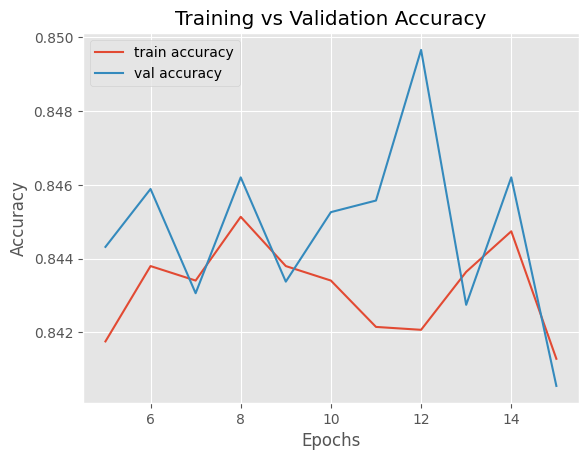

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(np.arange(5,16),hist.history['accuracy'],label='train accuracy')
plt.plot(np.arange(5,16),hist.history['val_accuracy'],label='val accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")

Text(0.5, 1.0, 'Training vs Validation Loss')

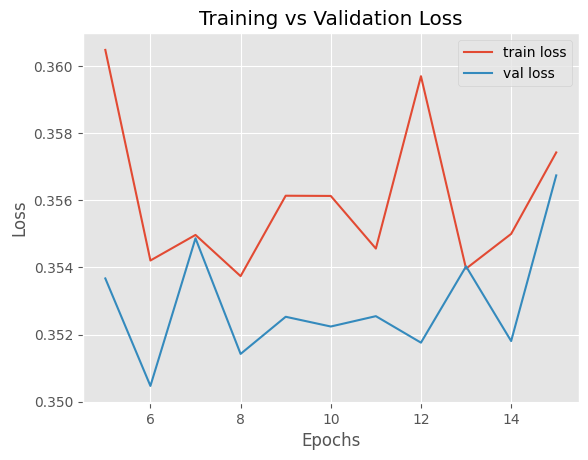

In [ ]:
plt.plot(np.arange(5,16),hist.history['loss'],label='train loss')
plt.plot(np.arange(5,16),hist.history['val_loss'],label='val loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")

In [34]:
y_pred=model.predict(x_val)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [35]:
y_pred=[1 if i>0.5 else 0 for i in y_pred]
confusion_matrix(y_pred,y_val)

array([[1276,  282],
       [ 258, 1370]])

In [36]:
print(classification_report(y_pred,y_val))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      1558
           1       0.83      0.84      0.84      1628

    accuracy                           0.83      3186
   macro avg       0.83      0.83      0.83      3186
weighted avg       0.83      0.83      0.83      3186

